## Poisson Blending

<p style='direction:rtl; text-align: right'>
برای پیاده سازی روش Poisson Blending در این تمرین، دو تصویر به همراه ماسکی که این دو را ترکیب کند، به عنوان ورودی دریافت میکنیم.
سپس دور ناحیه ماسک عکس هدف، یک مستطیل فرضی در نظر میگیریم و محسابات را داخل آن مستطیل انجام می‌دهیم تا حجم محسابات کمتر و
همچنین پیچیدگی کمتری داشته باشد.
<br>
به طور دقیق‌تر، در دستگاه معادلات مربوط به مسئله، تمامی پیکسل‌های آن ناحیه مستطیلی را می‌‌آوریم. این باعث می‌شود تا در نهایت
ماتریس دستگاه به صورت نواری شود که ساخت آن سریع‌تر است و با توجه به تنک بودن‌ آن، روش‌های سریعی نیز برای حل معادله وجود دارد.
پس از حل معادله و به دست آوردن تصویر جدید، آن را در ناحیه مستطیلی‌ای که در نظر گرفته بودیم جای‌گذاری میکنیم.
البته توجه کنید از آنجایی که نیاز به مقادیر پیکسل‌های دور ناحیه ماسک داریم، پس مستطیل محیطی را با یک واحد آفست در نظر میگیریم.
<br>
در نهایت، از آنجایی که جواب معادله ممکن است خارج از محدوده فضای رنگی باشد، آن را بین صفر و یک قطع میکنیم.
</p>


<p style='direction:rtl; text-align: right'>
ابتدا دو عکس و ماسکشان را ورودی میگیریم.
</p>


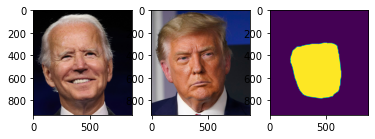

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import util, color
from scipy import sparse
from scipy.sparse.linalg import spsolve

src = util.img_as_float64(plt.imread('1.source.jpg'))
tar = util.img_as_float64(plt.imread('2.target.jpg'))
mask = color.rgb2gray(color.rgba2rgb(plt.imread('mask_trump_biden.png')))[:, :, None]

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(src)
ax[1].imshow(tar)
ax[2].imshow(mask)
plt.show()

<p style='direction:rtl; text-align: right'>
سپس مختصات نقاط داخل ماسک را به دست می‌آوریم و مستطیل محیطی را محسابه می‌کنیم. در نهایت ناحیه‌ای به اندازه این مستطیل از
تصاویر جدا میکنیم.
</p>

In [2]:
mask_arg = np.argwhere(mask > 0.01)
c_area = (mask_arg[:, 0].min() - 2, mask_arg[:, 1].min() - 2, mask_arg[:, 0].max() + 3, mask_arg[:, 1].max() + 3)

src_r = src[c_area[0]:c_area[2], c_area[1]:c_area[3]].copy()
tar_r = tar[c_area[0]:c_area[2], c_area[1]:c_area[3]].copy()
mask_r = mask[c_area[0]:c_area[2], c_area[1]:c_area[3]].copy()

shape_r = tar_r.shape
size = shape_r[0] * shape_r[1]

<p style='direction:rtl; text-align: right'>
از عکس مرجع باید لاپلاسین آن را استخراج کنیم.
</p>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


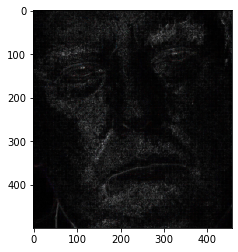

In [3]:
tar_r_lap = cv.Laplacian(tar_r, cv.CV_64F)

plt.imshow(np.abs(tar_r_lap))
plt.show()

<p style='direction:rtl; text-align: right'>
حال با توجه به مستطیلی بودن ناحیه، ماتریس دستگاه ۵ قطری خواهد بود. برای نقاط خارج از ماسک، معادله $f_ij = g_ij$ را در نظر میگیریم
و برای نقاط داخل ماسک معادله
<br>
</p>


$$-4f_{i,j} + f_{i+1,j}+ f_{i-1,j}+ f_{i,j+1}+ f_{i,j-1} = \nabla^2 g_{i,j}$$


<p style='direction:rtl; text-align: right'>
که در اینجا $$f$$ عکس هدف و $$g$$ عکس مرجع است.
<br>
سپس در نهایت ماتریس قطری مربوط به آن را می‌سازیم.
</p>

In [4]:
diags = np.zeros((5, size))
offsets = [0, -1, 1, -shape_r[1], shape_r[1]]

ind_mask = np.argwhere(mask_r > 0.01)
ind_mask = ind_mask[:, 0] * shape_r[1] + ind_mask[:, 1]

diags[0, :] = 1
diags[:, ind_mask] = 1
diags[0, ind_mask] = -4
for i, offset in enumerate(offsets):
    diags[i, :] = np.roll(diags[i, :], offset) # offset in dia_matrix is in i's direction so we need a shift in our values to make it in j's direction

mat = sparse.dia_matrix((diags, offsets), (size, size))

<p style='direction:rtl; text-align: right'>
بردار جواب‌ها را نیز بر حسب دو تصویر می‌سازیم.
</p>

In [5]:
vec = src_r.copy().reshape((size, 3))
vec[ind_mask] = tar_r_lap.reshape((size, 3))[ind_mask]

<p style='direction:rtl; text-align: right'>
دستگاه را با روش‌های ماتریس تنک حل می‌کنیم و تصویر نهایی را به دست می‌آوریم.
</p>

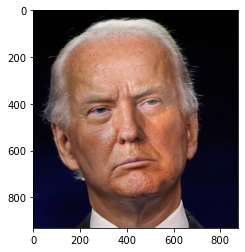

In [6]:
res_r = spsolve(mat.tocsr(), vec)
res_r = res_r.reshape(shape_r)

res = src.copy()
res[c_area[0]:c_area[2], c_area[1]:c_area[3]] = res_r

res = np.clip(res, 0, 1)

plt.imshow(res)
plt.show()
